## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Загружаем исходные данные

In [2]:
train = np.loadtxt('C:/temp/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('C:/temp/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

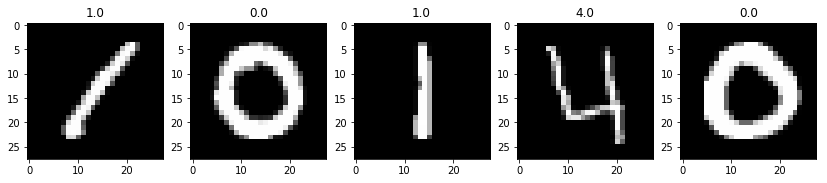

In [4]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [5]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [6]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [7]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [8]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

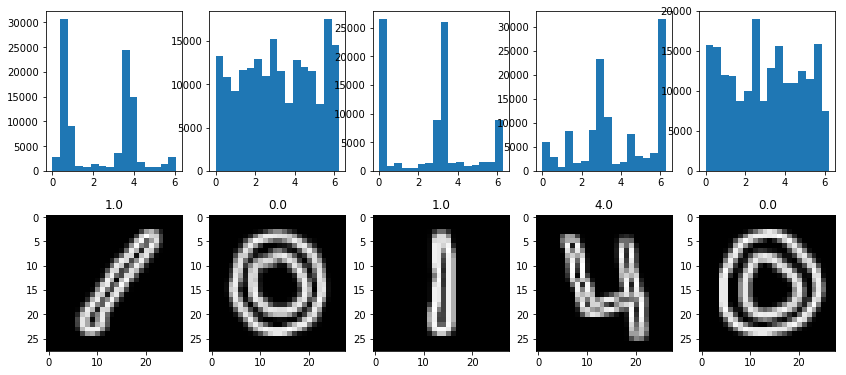

In [9]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [10]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 64))
for i in range(len(train_img)):
    hist1, borders1 = np.histogram(train_theta[i][:13,:13],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i][:13,:13])
    hist2, borders2 = np.histogram(train_theta[i][:13,13:],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i][:13,13:])
    hist3, borders3 = np.histogram(train_theta[i][13:,:13],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i][13:,:13])
    hist4, borders4 = np.histogram(train_theta[i][:13,:13],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i][:13,:13])
    train_hist[i] = np.concatenate( (hist1,hist2,hist3,hist4), axis=0)

In [11]:
# Гистограммы вычисляются с учетом длины вектора градиента
test_hist = np.zeros((len(test_img), 64))
for i in range(len(test_img)):
    hist1, borders1 = np.histogram(test_theta[i][:13,:13],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i][:13,:13])
    hist2, borders2 = np.histogram(test_theta[i][:13,13:],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i][:13,13:])
    hist3, borders3 = np.histogram(test_theta[i][13:,:13],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i][13:,:13])
    hist4, borders4 = np.histogram(test_theta[i][:13,:13],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i][:13,:13])
    test_hist[i] = np.concatenate( (hist1,hist2,hist3,hist4), axis=0)

## Нормируем вектор гистограммы

In [12]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [13]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Собираем полносвязную сеть для обучения

In [14]:
train_hist.shape

(42000, 64)

In [43]:
model = keras.models.Sequential()
n = 256
model.add(keras.layers.Dense(n, input_dim=train_hist.shape[1], activation='relu'))
model.add(keras.layers.Dense(n, activation='relu'))
#model.add(keras.layers.Dense(n, activation='relu'))
model.add(keras.layers.Dense(n, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Выводим информацию о модели

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_21 (Dense)             (None, 10)                2570      
Total params: 150,794
Trainable params: 150,794
Non-trainable params: 0
_________________________________________________________________


## One hot encoding разметки

In [45]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(train_label)
print( train_label.shape, y_train_labels.shape, train_hist.shape)

(42000,) (42000, 10) (42000, 64)


## Запускаем обучение

In [46]:
model.fit(train_hist, y_train_labels, batch_size=100, epochs=60)

Epoch 1/60
42000/42000 [==============================] - 4s - loss: 0.5239 - acc: 0.8323     
Epoch 2/60
42000/42000 [==============================] - 3s - loss: 0.2685 - acc: 0.9125     
Epoch 3/60
42000/42000 [==============================] - 3s - loss: 0.2232 - acc: 0.9271     
Epoch 4/60
42000/42000 [==============================] - 3s - loss: 0.1991 - acc: 0.9334     
Epoch 5/60
42000/42000 [==============================] - 3s - loss: 0.1787 - acc: 0.9417     
Epoch 6/60
42000/42000 [==============================] - 3s - loss: 0.1622 - acc: 0.9470     
Epoch 7/60
42000/42000 [==============================] - 3s - loss: 0.1522 - acc: 0.9496     
Epoch 8/60
42000/42000 [==============================] - 3s - loss: 0.1406 - acc: 0.9531     
Epoch 9/60
42000/42000 [==============================] - 4s - loss: 0.1306 - acc: 0.9565     
Epoch 10/60
42000/42000 [==============================] - 3s - loss: 0.1232 - acc: 0.9593     
Epoch 11/60
42000/42000 [========================

## Предсказания на тестовыйх данных

In [47]:
predicted_test = model.predict_classes(test_hist)

27552/28000 [============================>.] - ETA: 0s

In [48]:
predicted_test[0:5]

array([2, 0, 9, 8, 3], dtype=int64)

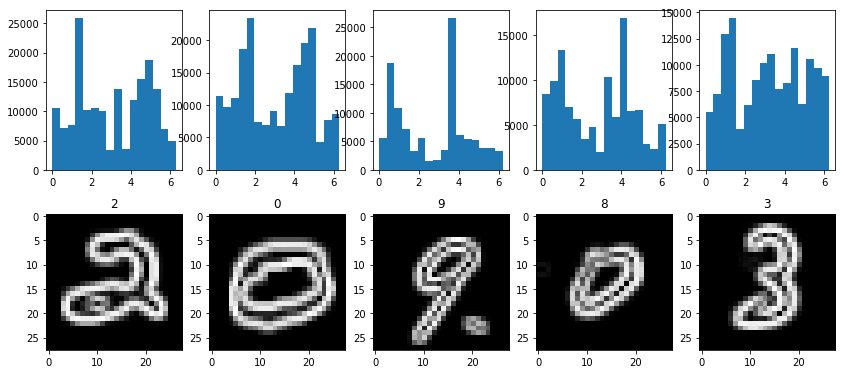

In [49]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % predicted_test[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(test_theta[i - 1].flatten(), bins=16, weights=test_g[i - 1].flatten())

In [50]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(predicted_test, 1):
        dst.write('%s,%s\n' % (i, p))